Mounted at /content/drive
Sleep Cassette (SC): 153 subjects
Sleep Telemetry (ST): 44 subjects
Sleep Cassette (SC): 153 subjects
Sleep Telemetry (ST): 44 subjects
EEG Signal File: /content/drive/MyDrive/SleepEDF/SC4001E0-PSG.edf
Annotation File: /content/drive/MyDrive/SleepEDF/SC4001EC-Hypnogram.edf
Extracting EDF parameters from /content/drive/MyDrive/SleepEDF/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-1515856543.py:44: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
/tmp/ipython-input-1515856543.py:44: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
/tmp/ipython-input-1515856543.py:44: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1515856543.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | his_id: X, sex: 2, first_name: Female, last_name: 33yr>
>
Using matplotlib as 2D backend.


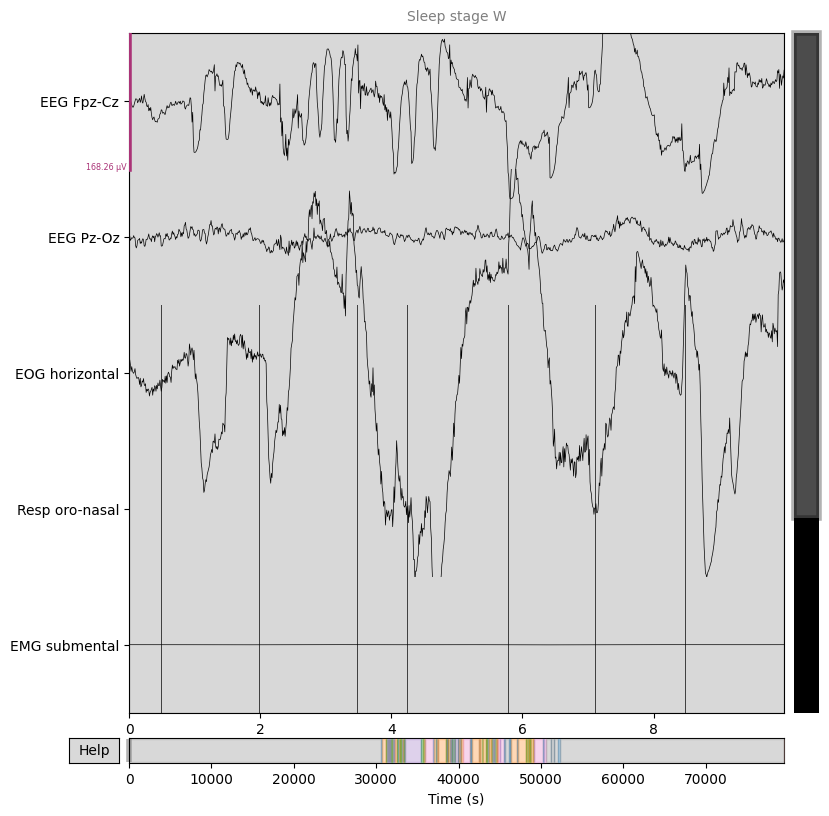

EEG shape: (7, 7950000)
Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Event IDs (sleep stages): {np.str_('Sleep stage 1'): 1, np.str_('Sleep stage 2'): 2, np.str_('Sleep stage 3'): 3, np.str_('Sleep stage 4'): 4, np.str_('Sleep stage ?'): 5, np.str_('Sleep stage R'): 6, np.str_('Sleep stage W'): 7}


In [3]:
# Install required Python packages
!pip install mne pyedflib tensorflow

# Import necessary libraries
import mne                     # For EEG/EDF file processing
import numpy as np             # For numerical operations
import tensorflow as tf        # For deep learning model building
from sklearn.model_selection import train_test_split  # For splitting dataset into train/test
from sklearn.preprocessing import LabelEncoder        # For encoding labels into integers
import matplotlib.pyplot as plt # For plotting graphs
import pandas as pd             # For data handling
import os                       # For file handling

# Mount Google Drive to access data stored there
from google.colab import drive
drive.mount('/content/drive')

# Path to Sleep-EDF dataset in Google Drive
edf_dir = '/content/drive/MyDrive/SleepEDF'
files = os.listdir(edf_dir)  # List all files in the directory

# Separate PSG (EEG signal) and Hypnogram (annotations) files for Sleep Cassette (SC) recordings
sc_psg = sorted([f for f in files if f.startswith('SC') and f.endswith('PSG.edf')])
sc_ann = sorted([f for f in files if f.startswith('SC') and f.endswith('Hypnogram.edf')])

# Separate PSG (EEG signal) and Hypnogram (annotations) files for Sleep Telemetry (ST) recordings
st_psg = sorted([f for f in files if f.startswith('ST') and f.endswith('PSG.edf')])
st_ann = sorted([f for f in files if f.startswith('ST') and f.endswith('Hypnogram.edf')])

# Display number of subjects in each category
print(f"Sleep Cassette (SC): {len(sc_psg)} subjects")
print(f"Sleep Telemetry (ST): {len(st_psg)} subjects")
print(f"Sleep Cassette (SC): {len(sc_ann)} subjects")
print(f"Sleep Telemetry (ST): {len(st_ann)} subjects")

# Select the first SC subject’s EEG signal and annotation files
psg_file = edf_dir + '/' + sc_psg[0]  # EEG signal file path
ann_file = edf_dir + '/' + sc_ann[0]  # Annotation file path

print("EEG Signal File:", psg_file)
print("Annotation File:", ann_file)

# Load the EEG data from EDF file
raw = mne.io.read_raw_edf(psg_file, preload=True)

# Load annotations (sleep stage labels)
annotations = mne.read_annotations(ann_file)

# Attach annotations to the EEG data
raw.set_annotations(annotations)

# Keep only EEG channels (ignore EOG, EMG, etc.)
raw.pick_types(eeg=True)

# Display EEG recording info
print(raw.info)

# Plot first 5 EEG channels for visualization
raw.plot(n_channels=5, scalings='auto')

# Get EEG data as a NumPy array
eeg_data = raw.get_data()
print("EEG shape:", eeg_data.shape)

# Extract events and mapping from annotations
events, event_id = mne.events_from_annotations(raw)
print("Event IDs (sleep stages):", event_id)

# Sampling frequency (Hz)
sfreq = int(raw.info['sfreq'])

# Epoch length: 30 seconds → number of samples in each epoch
epoch_length = 30
epoch_samples = sfreq * epoch_length

# Prepare lists to store EEG epochs and their labels
eeg_epochs = []
labels = []

# Loop over annotations and segment EEG data into 30s epochs
for annot in annotations:
    if annot['description'] == 'Sleep stage ?':  # Skip unknown sleep stages
        continue
    start = int(annot['onset'] * sfreq)          # Start sample index
    duration = int(annot['duration'] * sfreq)    # Duration in samples
    # Create 30s segments within this annotation duration
    for i in range(0, duration, epoch_samples):
        segment = eeg_data[0, start + i : start + i + epoch_samples]
        if segment.shape[0] == epoch_samples:    # Ensure correct length
            eeg_epochs.append(segment)
            labels.append(annot['description'])

# Map sleep stage descriptions to integer labels
stage_dict = {
    'Sleep stage W': 0,  # Wake
    'Sleep stage 1': 1,  # N1 (light sleep)
    'Sleep stage 2': 2,  # N2
    'Sleep stage 3': 3,  # N3 (deep sleep)
    'Sleep stage 4': 4,  # N4 (older classification of deep sleep)
    'Sleep stage R': 5   # REM sleep
}


In [4]:
def extract_epochs_from_subject(psg_path, ann_path, channel_pick='EEG Fpz-Cz'):
    """
    Extracts 30-second EEG epochs and corresponding sleep stage labels
    from a single subject's PSG (EEG) and annotation files.

    Parameters:
    -----------
    psg_path : str
        Path to the EEG signal file (PSG .edf file)
    ann_path : str
        Path to the annotation file (Hypnogram .edf file)
    channel_pick : str, optional
        The EEG channel to use (default is 'EEG Fpz-Cz').
        If the channel is not available, picks all EEG channels.

    Returns:
    --------
    epochs : np.ndarray
        NumPy array of shape (num_epochs, samples_per_epoch) containing EEG data segments
    labels : np.ndarray
        NumPy array containing integer-encoded sleep stage labels for each epoch
    """

    # Load raw EEG data from PSG file
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

    # Downsample EEG data to 25 Hz to reduce processing load
    raw.resample(25)

    # Load annotation (sleep stage) data
    annotations = mne.read_annotations(ann_path)

    # Attach annotations to the EEG data
    raw.set_annotations(annotations)

    # Pick the desired EEG channel if available, otherwise select all EEG channels
    if channel_pick in raw.ch_names:
        raw.pick_channels([channel_pick])
    else:
        raw.pick_types(eeg=True)

    # Extract EEG signal data as a NumPy array
    eeg_data = raw.get_data()

    # Get sampling frequency
    sfreq = int(raw.info['sfreq'])

    # Define epoch length (30 seconds) in both seconds and number of samples
    epoch_length = 30
    epoch_samples = sfreq * epoch_length

    # Lists to store EEG epochs and their labels
    epochs = []
    labels = []

    # Loop through each annotation and create 30-second segments
    for annot in annotations:
        desc = annot['description']  # Sleep stage name (e.g., 'Sleep stage W')

        # Skip if the sleep stage is not in our mapping dictionary
        if desc not in stage_dict:
            continue

        # Convert onset time and duration from seconds to samples
        start = int(annot['onset'] * sfreq)
        duration = int(annot['duration'] * sfreq)

        # Split the annotation period into multiple 30-second epochs
        for i in range(0, duration, epoch_samples):
            segment = eeg_data[0, start + i : start + i + epoch_samples]

            # Only keep segments with exactly 30 seconds of data
            if segment.shape[0] == epoch_samples:
                epochs.append(segment)
                labels.append(stage_dict[desc])  # Convert stage name to integer label

    # Return EEG epochs and labels as NumPy arrays
    return np.array(epochs), np.array(labels)


In [5]:
# Lists to store EEG data and labels from all subjects
X_epochs = []
y_epochs = []

# Load Sleep Cassette (SC) subjects → Healthy group

for psg, ann in zip(sc_psg, sc_ann):
    try:
        # Extract 30s EEG epochs and corresponding labels for this subject
        X, y = extract_epochs_from_subject(
            os.path.join(edf_dir, psg),  # Path to PSG (EEG) file
            os.path.join(edf_dir, ann)   # Path to annotation file
        )
        X_epochs.append(X)  # Add EEG data
        y_epochs.append(y)  # Add labels
    except Exception as e:
        # If an error occurs, skip this file and print the reason
        print(f"Skipping {psg} due to {e}")


# Load Sleep Telemetry (ST) subjects → Disordered group

for psg, ann in zip(st_psg, st_ann):
    try:
        X, y = extract_epochs_from_subject(
            os.path.join(edf_dir, psg),
            os.path.join(edf_dir, ann)
        )
        X_epochs.append(X)
        y_epochs.append(y)
    except Exception as e:
        print(f"Skipping {psg} due to {e}")

# Combine all subjects into single arrays
X = np.concatenate(X_epochs)  # Shape → (total_samples, samples_per_epoch)
y = np.concatenate(y_epochs)  # Shape → (total_samples,)
print("EEG shape:", X.shape)


# Normalize EEG data
# For each epoch, subtract the mean and divide by the standard deviation
#  This makes data zero-centered with unit variance
X_norm = (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

# Add channel dimension for deep learning models (Conv1D/LSTM expect [samples, time_steps, channels])
X_norm = X_norm[..., np.newaxis]  # Shape → (samples, time_steps, 1)

print("Normalized EEG shape:", X_norm.shape)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y,
    test_size=0.2,          # 20% test data
    random_state=42,        # Reproducibility
    stratify=y              # Preserve class distribution
)

# Build Deep Learning Model (CNN + LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
import numpy as np  # Ensure numpy is imported

# Define sequential model
model = Sequential([
    tf.keras.Input(shape=(X.shape[1], 1)),   # Input shape → (time_steps, channels)

    # Convolutional layer: extracts local temporal patterns
    Conv1D(32, kernel_size=5, activation='relu'),

    # Pooling layer: reduces sequence length and computation
    MaxPooling1D(pool_size=2),

    # LSTM layer: learns temporal dependencies (returns full sequence for next LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.3),  # Dropout to prevent overfitting

    # Second LSTM layer: outputs only the last hidden state
    LSTM(32),

    # Dense layer: learns complex combinations of features
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer: softmax for multi-class classification
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile model with Adam optimizer and sparse categorical loss
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use integer labels (not one-hot)
    metrics=['accuracy']
)


/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1728551117.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1728551117.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipython-input-1728551117.py:25: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Skipping SC4011E0-PSG.edf due to [Errno 107] Transport endpoint is not connected
Skipping SC4012E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4012E0-PSG.edf'
Skipping SC4021E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4021E0-PSG.edf'
Skipping SC4022E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4022E0-PSG.edf'
Skipping SC4031E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4031E0-PSG.edf'
Skipping SC4032E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4032E0-PSG.edf'
Skipping SC4041E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4041E0-PSG.edf'
Skipping SC4042E0-PSG.edf due to [Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/SleepEDF/SC4042

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 50s 363ms/step - accuracy: 0.7013 - loss: 1.0282 - val_accuracy: 0.7089 - val_loss: 0.8635
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 80s 351ms/step - accuracy: 0.7047 - loss: 0.8952 - val_accuracy: 0.7099 - val_loss: 1.0382
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 81s 339ms/step - accuracy: 0.7046 - loss: 0.9633 - val_accuracy: 0.7336 - val_loss: 0.8412
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 49s 358ms/step - accuracy: 0.7301 - loss: 0.8378 - val_accuracy: 0.7089 - val_loss: 1.2078
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 363ms/step - accuracy: 0.7150 - loss: 1.0105 - val_accuracy: 0.7281 - val_loss: 0.8547
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 363ms/step - accuracy: 0.7005 - loss: 0.9072 - val_accuracy: 0.7162 - val_loss: 0.8044
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 78s 339ms/step - accuracy: 0.7129 - loss: 0.8402 - val_accuracy: 0.7318 - val_loss: 0.7695
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 81s 335ms/step - accuracy: 0.7148 - loss: 0

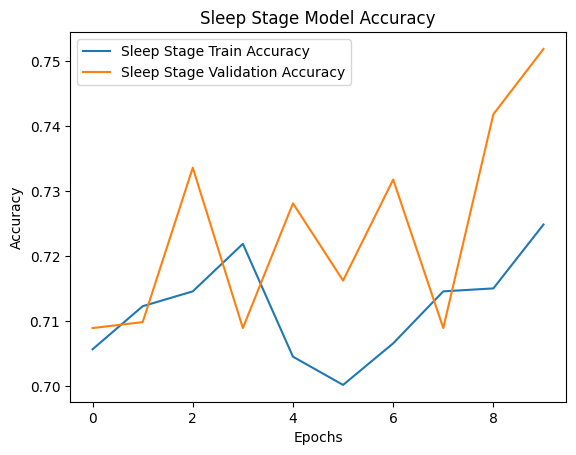

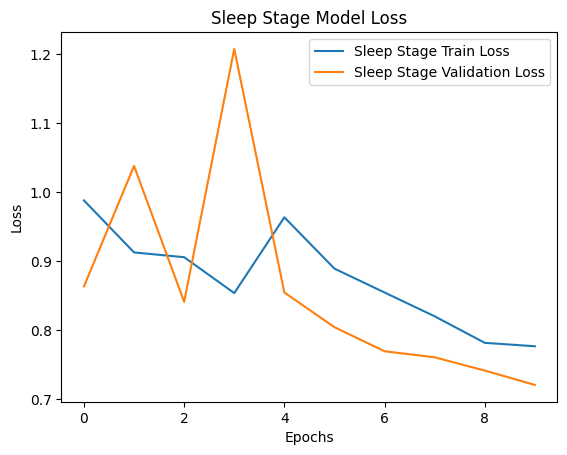

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Combine all EEG epochs and labels into single arrays
X_all = np.concatenate(X_epochs, axis=0)  # Shape: (total_samples, samples_per_epoch)
y_all = np.concatenate(y_epochs, axis=0)  # Shape: (total_samples,)

# Normalize EEG data using zero mean and unit variance scaling
# Neural networks perform better with standardized inputs
scaler = StandardScaler()
X_all = scaler.fit_transform(
    X_all.reshape(-1, X_all.shape[-1])  # Flatten for scaling
).reshape(X_all.shape)                  # Reshape back to original format

# Split data into training and testing sets while preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,        # 20% data for testing
    random_state=42,      # For reproducibility
    stratify=y_all        # Maintain same class proportions
)

# Add a channel dimension so Conv1D/LSTM layers can process the data
X_train = X_train[..., np.newaxis]  # Shape becomes (samples, time_steps, 1)
X_test = X_test[..., np.newaxis]

# Train the model and store training history for plotting later
history = model.fit(
    X_train, y_train,
    epochs=10,              # Number of complete passes over the dataset
    batch_size=32,          # Samples per gradient update
    validation_data=(X_test, y_test)  # Monitor performance on test set during training
)

# Evaluate the trained model on the test dataset
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

# Plot training vs validation accuracy over epochs
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Sleep Stage Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Sleep Stage Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sleep Stage Model Accuracy')
plt.legend()
plt.show()

# Plot training vs validation loss over epochs
plt.plot(history.history['loss'], label='Sleep Stage Train Loss')
plt.plot(history.history['val_loss'], label='Sleep Stage Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Sleep Stage Model Loss')
plt.legend()
plt.show()


In [8]:
# disorder_labels: 0 = healthy (SC), 1 = disordered (ST)
disorder_labels = []

for i, (Xsubj, psg) in enumerate(zip(X_epochs, sc_psg + st_psg)):
    # SC files come first, so label as 0 (healthy) for SC subjects, 1 for ST subjects
    label = 0 if i < len(sc_psg) else 1
    disorder_labels.extend([label] * len(Xsubj))

disorder_labels = np.array(disorder_labels)
X_disorder = np.concatenate(X_epochs, axis=0)

# Normalize, if not already done (reuse your scaler from sleep stage prep)
X_disorder = scaler.transform(X_disorder.reshape(-1, X_disorder.shape[-1])).reshape(X_disorder.shape)

# Train/test split for disorder detection
from sklearn.model_selection import train_test_split

X_train_disorder, X_test_disorder, y_train_disorder, y_test_disorder = train_test_split(
    X_disorder, disorder_labels, test_size=0.2, random_state=42, stratify=disorder_labels)

# Reshape for CNN input
X_train_disorder = X_train_disorder[..., np.newaxis]
X_test_disorder  = X_test_disorder[..., np.newaxis]


In [9]:
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.models import Sequential

# Define a CNN-LSTM model for sleep disorder detection
disorder_model = Sequential([
    tf.keras.Input(shape=(X.shape[1], 1)),

    # CNN layers to extract features from raw EEG epochs
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # LSTM layer to capture temporal dependencies
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    # Final classification dense layer for binary output
    Dense(1, activation='sigmoid')
])

disorder_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Then train and evaluate as before
history_disorder = disorder_model.fit(
    X_train_disorder, y_train_disorder,
    epochs=10, batch_size=32,
    validation_data=(X_test_disorder, y_test_disorder)
)

test_loss_disorder, test_acc_disorder = disorder_model.evaluate(X_test_disorder, y_test_disorder)
print("Disorder Detection CNN-LSTM Test Accuracy:", test_acc_disorder)
print("Disorder Detection CNN-LSTM Test Loss:", test_loss_disorder)


Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 34s 209ms/step - accuracy: 0.9863 - loss: 0.1170 - val_accuracy: 1.0000 - val_loss: 1.1346e-04
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 1.0000 - loss: 2.3929e-04 - val_accuracy: 1.0000 - val_loss: 5.5858e-05
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 1.0000 - loss: 1.2302e-04 - val_accuracy: 1.0000 - val_loss: 3.5596e-05
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 1.0000 - loss: 9.4407e-05 - val_accuracy: 1.0000 - val_loss: 2.3372e-05
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 1.0000 - loss: 6.6955e-05 - val_accuracy: 1.0000 - val_loss: 1.6417e-05
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 23s 154ms/step - accuracy: 1.0000 - loss: 4.7127e-05 - val_accuracy: 1.0000 - val_loss: 1.2995e-05
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 1.0000 - loss: 4.6056e-05 - val_accuracy: 1.0000 - val_loss: 1.0666e-05
Epoch 8/10
137/137 ━━━━━━━━━━━━

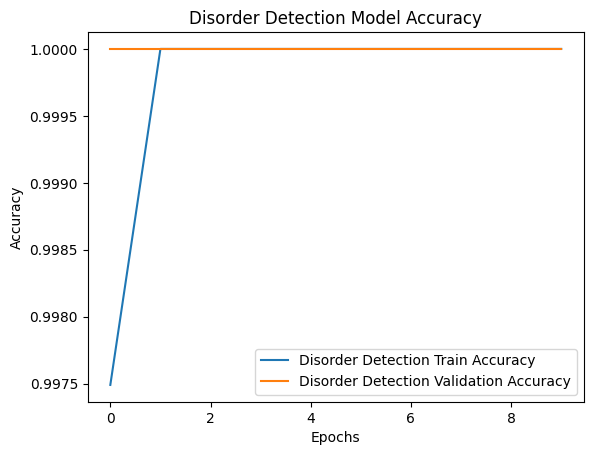

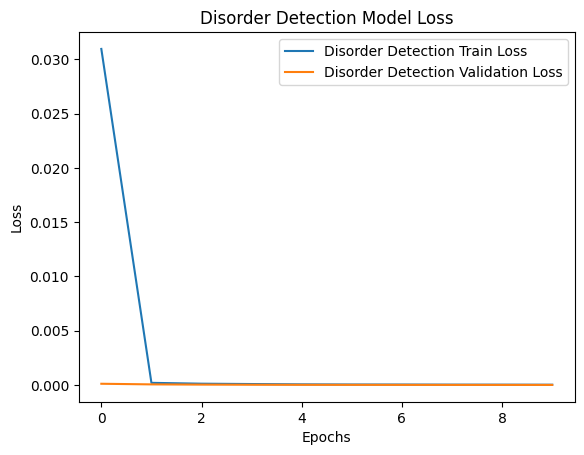

In [10]:
#plotting training accuracy and loss
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_disorder.history['accuracy'], label='Disorder Detection Train Accuracy')
plt.plot(history_disorder.history['val_accuracy'], label='Disorder Detection Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Disorder Detection Model Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history_disorder.history['loss'], label='Disorder Detection Train Loss')
plt.plot(history_disorder.history['val_loss'], label='Disorder Detection Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Disorder Detection Model Loss')
plt.legend()
plt.show()

In [11]:
disorder_model.save('/content/drive/MyDrive/final_model.h5')
print("Model saved to drive.")

Model saved to drive.
